Muhammad Suleman - 2278851
 - *Joint Semantic-Geometric Learning for Polygonal Building Segmentation*

# Downlod dataset from kaggle
* https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
! pip install kaggle  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

## Download OpenAI Mapping Challenge Dataset
* https://www.kaggle.com/datasets/kmader/synthetic-word-ocr

In [5]:
! kaggle datasets download kmader/synthetic-word-ocr

synthetic-word-ocr.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the Dataset
!unzip "/content/synthetic-word-ocr.zip" -d "/content/"

# Preprocess the Dataset

In [7]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from skimage.io import imread
from skimage.transform import resize
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np

In [8]:
map_base_dir = '/content/'
map_img_dir = '/content/train/images/'

In [9]:
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

## Image Dataframe

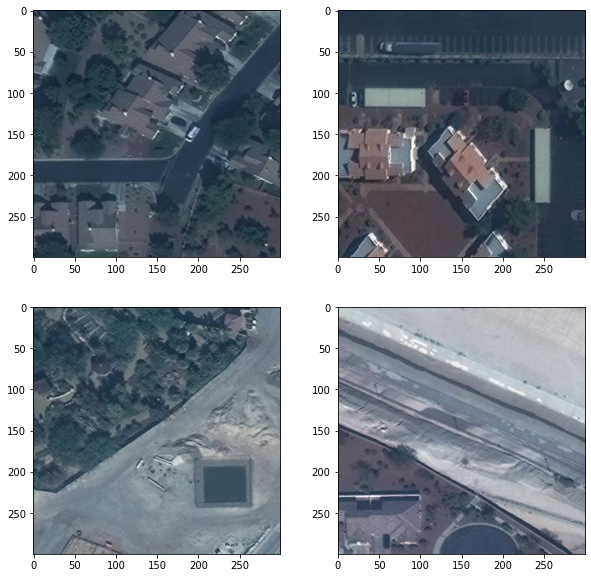

In [10]:
image_df = pd.DataFrame(annot_data['images'])
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    # print(c_ax)
    # print(c_row)
    # print(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

000000043981.jpg
/content/train/images/000000043981.jpg


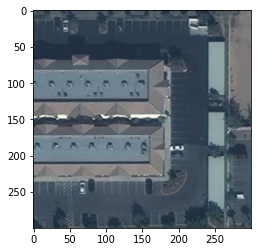

000000185632.jpg
/content/train/images/000000185632.jpg


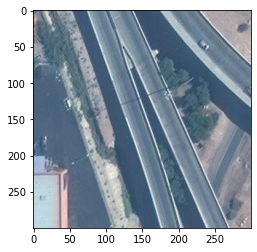

000000025892.jpg
/content/train/images/000000025892.jpg


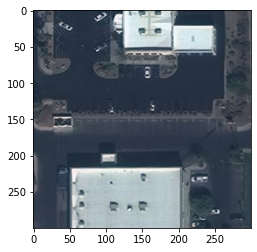

000000075766.jpg
/content/train/images/000000075766.jpg


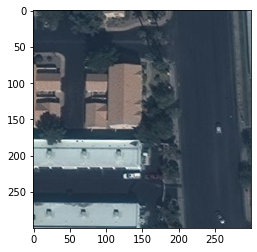

In [11]:
for i  in image_df.sample(4).iterrows():
  print(i[1]['file_name'])
  file_path = os.path.join(map_img_dir, i[1]['file_name'])
  print(file_path)
  img_data = imread(file_path)
  imgplot = plt.imshow(img_data)
  plt.show()

In [12]:
image_df.sample(3)

,id,file_name,width,height
63741,49224,000000049224.jpg,300,300
223555,231786,000000231786.jpg,300,300
100640,137879,000000137879.jpg,300,300


## Annotations Dataframe

In [13]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
393499,1727535,202549,"[[99.0, 300.0, 101.0, 266.0, 223.0, 276.0, 222...",3562.0,"[99.0, 99.0, 201.0, 124.0]",100,0
63340,1869308,219279,"[[101.0, 3.0003846579110155e-15, 101.0, 3.0000...",96.0,"[3.0003846579110155e-15, 69.0, 101.0, 32.0]",100,0
897914,1251581,146824,"[[125.0, 281.0, 125.0, 299.0, 112.0, 299.0, 11...",234.0,"[112.0, 112.0, 187.0, 13.0]",100,0


In [14]:
dummy = annot_df.iloc[0]
print(dummy)

id                                                         460757
image_id                                                    54062
segmentation    [[300, 182, 297, 182, 296, 153, 300, 153, 300,...
area                                                        101.0
bbox                                           [182, 296, 118, 4]
category_id                                                   100
iscrowd                                                         0
Name: 0, dtype: object


## Merge Dataframes

In [15]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
2030581,2022606,237249,"[[123.0, 83.0, 152.0, 83.0, 152.0, 96.0, 175.0...",1807.0,"[83.0, 123.0, 92.0, 52.0]",100,0,237249,000000237249.jpg,300,300
199577,2267099,265705,"[[106, 12, 102, 24, 94, 22, 93, 24, 82, 51, 54...",1586.0,"[12, 54, 94, 52]",100,0,265705,000000265705.jpg,300,300


In [17]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

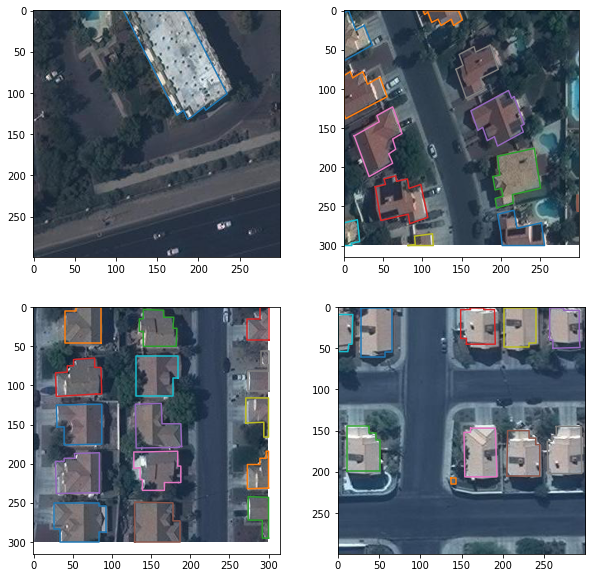

In [18]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        # print(xy_vec)
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [19]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

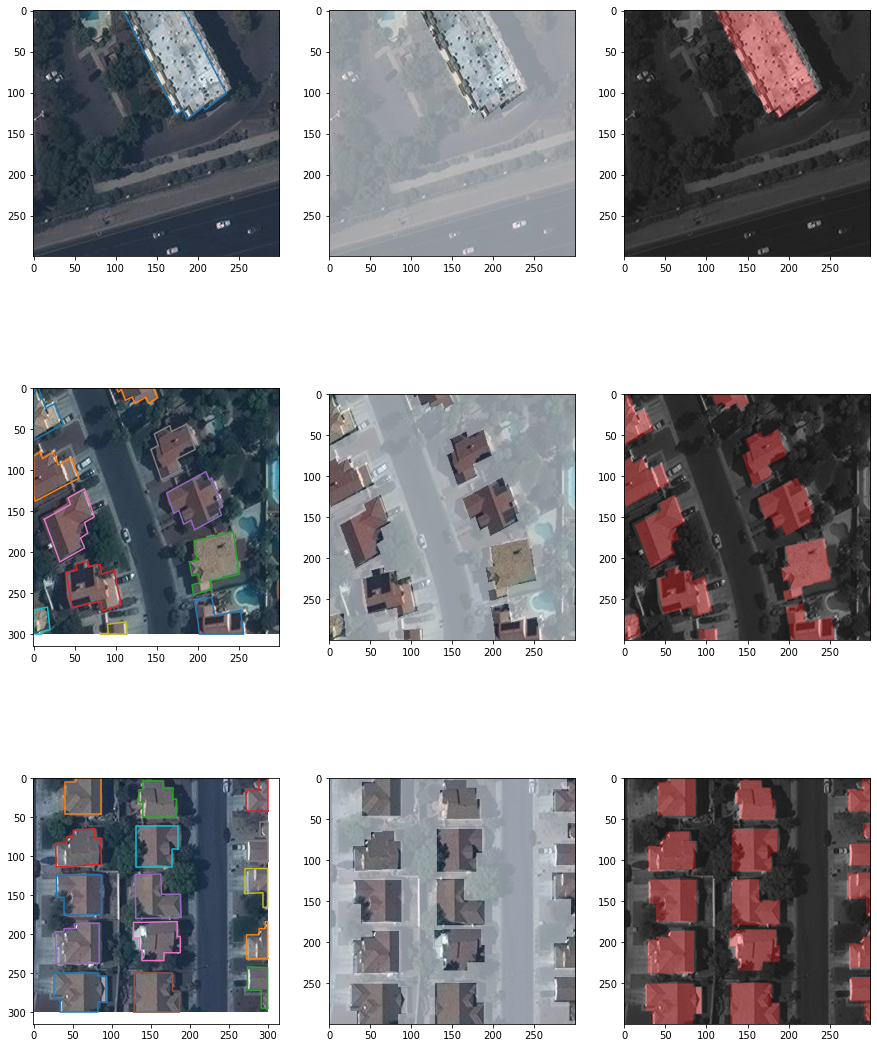

In [20]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

### Plot Single Picture
* Resize to 224x224 and transform segmentation points accordingly

/content/train/images/000000000001.jpg


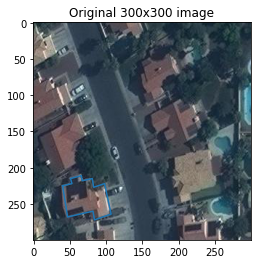

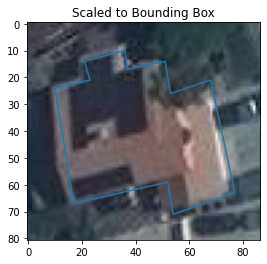

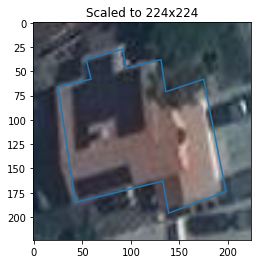

In [24]:
no = 736135

test1pic = full_df.iloc[no]['file_name']
file_path = os.path.join(map_img_dir, test1pic)
print(file_path)
img_data = imread(file_path)
plt.imshow(img_data)
xy_vec = np.array(full_df.iloc[no]['segmentation']).reshape((-1, 2))

plt.plot(xy_vec[:, 0], xy_vec[:, 1])
plt.title("Original 300x300 image")
plt.show()

hor_min = int(min(xy_vec[:,0]))
hor_max = int(max(xy_vec[:,0]))
ver_min = int(min(xy_vec[:,1]))
ver_max = int(max(xy_vec[:,1]))

#with tolerance (padding to bounding box)
tol = 10
hor_mint = max(0,hor_min-tol)
ver_mint = max(0,ver_min-tol)
hor_maxt = min(300,hor_max+tol)
ver_maxt = min(300,ver_max+tol)

new_image = img_data[ver_mint:ver_maxt,hor_mint:hor_maxt]
plt.imshow(new_image)
old_shape = new_image.shape


new_xy_vec = np.array([[x-hor_mint,y-ver_mint] for (x,y) in xy_vec])
plt.plot(new_xy_vec[:, 0], new_xy_vec[:, 1])
plt.title("Scaled to Bounding Box")
plt.show()

nnew_xy_vec = np.array([[ int((x*224)/old_shape[1]) , int((y*224)/old_shape[0]) ] for (x,y) in new_xy_vec])
image_resized = resize(new_image, (224, 224),anti_aliasing=True)
plt.imshow(image_resized)
plt.plot(nnew_xy_vec[:, 0], nnew_xy_vec[:, 1])
plt.title("Scaled to 224x224")
plt.show()

# ResNet50 Encoder BackBone 



In [29]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1+(dilation-1), bias=False, dilation=dilation)
        # I know it's weird to write the padding this way, just makes it clear :P
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, strides, dilations, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0],
            stride = strides[0], dilation = dilations[0])
        self.layer2 = self._make_layer(block, 128, layers[1], 
            stride = strides[1], dilation = dilations[1])
        self.layer3 = self._make_layer(block, 256, layers[2], 
            stride = strides[2], dilation = dilations[2])
        self.layer4 = self._make_layer(block, 512, layers[3], 
            stride = strides[3], dilation = dilations[3])
        self.avgpool = nn.AvgPool2d(7 * max(dilations), stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1,
        dilation=1):

        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        conv1_f = self.relu(x)
        x = self.maxpool(conv1_f)

        layer1_f = self.layer1(x)
        layer2_f = self.layer2(layer1_f)
        layer3_f = self.layer3(layer2_f)
        layer4_f = self.layer4(layer3_f)

        x = self.avgpool(layer4_f)
        x = x.view(x.size(0), -1)
        fc_f = self.fc(x)

        return fc_f, conv1_f, layer1_f, layer2_f, layer3_f, layer4_f

In [30]:
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SkipResnet50(nn.Module):
    def __init__(self, concat_channels=64, final_dim=128):
        super(SkipResnet50, self).__init__()

        # Default transform for all torchvision models
        self.normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])

        self.concat_channels = concat_channels
        self.final_dim = final_dim
        self.feat_size = 28

        self.image_feature_dim = 256
        self.resnet = ResNet(Bottleneck, layers=[3, 4, 6, 3], strides=[1, 2, 1, 1], 
            dilations=[1, 1, 2, 4])

        concat1 = nn.Conv2d(64, concat_channels, kernel_size=3, padding=1, bias=False)
        bn1 = nn.BatchNorm2d(concat_channels)
        relu1 = nn.ReLU(inplace=True)

        self.conv1_concat = nn.Sequential(concat1, bn1, relu1)

        concat2 = nn.Conv2d(256, concat_channels, kernel_size=3, padding=1, bias=False)
        bn2 = nn.BatchNorm2d(concat_channels)
        relu2 = nn.ReLU(inplace=True)
        up2 = torch.nn.Upsample(scale_factor=2, mode='bilinear')

        self.res1_concat = nn.Sequential(concat2, bn2, relu2, up2)

        concat3 = nn.Conv2d(512, concat_channels, kernel_size=3, padding=1, bias=False)
        bn3 = nn.BatchNorm2d(concat_channels)
        relu3 = nn.ReLU(inplace=True)
        up3 = torch.nn.Upsample(scale_factor=4, mode='bilinear')

        self.res2_concat = nn.Sequential(concat3, bn3, relu3, up3)

        concat4 = nn.Conv2d(2048, concat_channels, kernel_size=3, padding=1, bias=False)
        bn4 = nn.BatchNorm2d(concat_channels)
        relu4 = nn.ReLU(inplace=True)
        up4 = torch.nn.Upsample(scale_factor=4, mode='bilinear')

        self.res4_concat = nn.Sequential(concat4, bn4, relu4, up4)

        # Different from original, original used maxpool
        # Original used no activation here
        conv_final_1 = nn.Conv2d(4*concat_channels, 128, kernel_size=3, padding=1, stride=2,
            bias=False)
        bn_final_1 = nn.BatchNorm2d(128)
        conv_final_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2, bias=False)
        bn_final_2 = nn.BatchNorm2d(128)
        conv_final_3 = nn.Conv2d(128, final_dim, kernel_size=3, padding=1, bias=False)
        bn_final_3 = nn.BatchNorm2d(final_dim)

        self.conv_final = nn.Sequential(conv_final_1, bn_final_1, conv_final_2, bn_final_2,
            conv_final_3, bn_final_3)

    def reload(self, path):
        print ("Reloading resnet from: ", path)
        self.resnet.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))

    def forward(self, x):
        x = self.normalize(x)
        # Normalization

        fc_f, conv1_f, layer1_f, layer2_f, layer3_f, layer4_f = self.resnet(x)

        conv1_f = self.conv1_concat(conv1_f)
        layer1_f = self.res1_concat(layer1_f)
        layer2_f = self.res2_concat(layer2_f)
        layer4_f = self.res4_concat(layer4_f)

        concat_features = torch.cat((conv1_f, layer1_f, layer2_f, layer4_f), dim=1)

        final_features = self.conv_final(concat_features)

        return concat_features, final_features

    def normalize(self, x):
        individual = torch.unbind(x, dim=0)
        out = []
        for x in individual:
            out.append(self.normalizer(x))

        return torch.stack(out, dim=0)

if __name__ == '__main__':
    model = SkipResnet50()
    print ([a.size() for a in model(torch.randn(1,3,224,224))])


[torch.Size([1, 256, 112, 112]), torch.Size([1, 128, 28, 28])]


In [33]:
#Change image from 224,224,3 to 3,224,224
image_trs = image_resized.transpose(2,0,1)
image_trs.shape
torch_image = torch.from_numpy(image_trs).unsqueeze(0)
torch_image.shape
encoded = model(torch_image.float())
result = np.squeeze(encoded[0].detach().numpy(),axis = 0)#   np.squeeze(a, axis=None)[source]
tr_result = result.transpose(1,2,0)
result.shape
tr_result.shape

(112, 112, 256)

## Visualizing the feature map

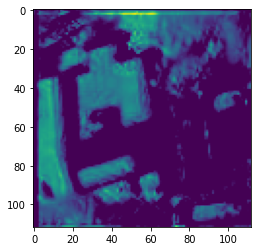

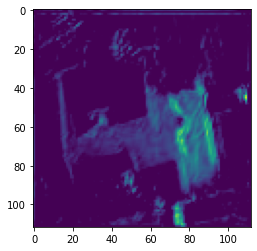

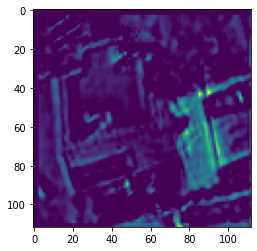

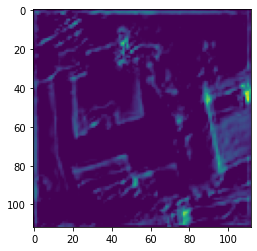

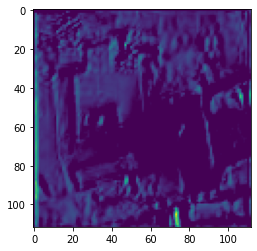

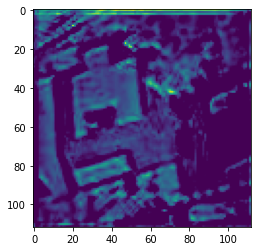

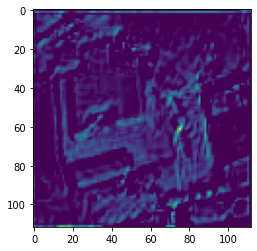

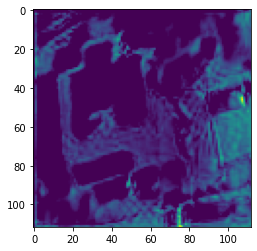

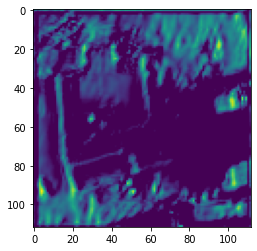

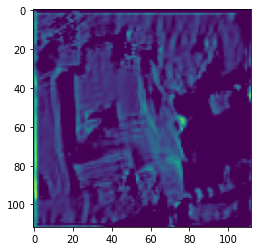

In [40]:
tr_result[:,:,1].shape
for i in range(5):
  plt.imshow(tr_result[:,:,i])
  plt.show()

# Vertex Embedding 

In [ ]:
# What are the vertice coordinates?
# Transform to 112x112 coordinates
# print(nnew_xy_vec)
rs_xy= np.array([[x//2,y//2] for (x,y) in nnew_xy_vec])
# print(rs_xy)

In [36]:
#What is shape of feature map?
tr_result.shape

(112, 112, 256)

In [37]:
rs_xy= np.array([[x//2,y//2] for (x,y) in nnew_xy_vec])
embeddings=[]
for i in rs_xy:
  embeddings.append(tr_result[i[1]][i[0]] )
embeddings = np.array(embeddings)
print("Shape of features of vertices")
print(embeddings.shape)

Shape of features of vertices
(13, 256)


# Propogation Model
* Predict displacement of vertex in 15x15 grid

## Prepare a dataset

In [45]:
random.seed(0)
for i in range(10):
  print([random.randint(-7, 7),random.randint(-7, 7)])

[6, -1]
[5, 7]
[-1, -7]
[-3, 1]
[0, -1]
[7, 5]
[6, -3]
[0, -2]
[2, 7]
[7, -4]


In [46]:
def bound(low, high, value):
    return max(low, min(high, value))

### With plots and print (Testing)

### Generating the Artificial Training Data

In [49]:

X_data=[]
y_data=[]

for no in range(0,500):
  displacement = []
  test1pic = full_df.iloc[no]['file_name']
  file_path = os.path.join(map_img_dir, test1pic)
  xy_vec = np.array(full_df.iloc[no]['segmentation']).reshape((-1, 2))

  hor_min = int(min(xy_vec[:,0]))
  hor_max = int(max(xy_vec[:,0]))
  ver_min = int(min(xy_vec[:,1]))
  ver_max = int(max(xy_vec[:,1]))

  #with tolerance
  tol = 10
  hor_mint = max(0,hor_min-tol)
  ver_mint = max(0,ver_min-tol)
  hor_maxt = min(300,hor_max+tol)
  ver_maxt = min(300,ver_max+tol)

  new_image = img_data[ver_mint:ver_maxt,hor_mint:hor_maxt]
  old_shape = new_image.shape
  new_xy_vec = np.array([[x-hor_mint,y-ver_mint] for (x,y) in xy_vec])

  nnew_xy_vec = np.array([[ int((x*224)/old_shape[1]) , int((y*224)/old_shape[0]) ] for (x,y) in new_xy_vec])
  ground_truth = np.copy(nnew_xy_vec)

  for i in range(len(nnew_xy_vec)-1):
    rand_displacement = [random.randint(-7, 7),random.randint(-7, 7)]
    displacement.append(rand_displacement)
    nnew_xy_vec[i] = [nnew_xy_vec[i][0]-rand_displacement[0],nnew_xy_vec[i][1]-rand_displacement[1]]
    nnew_xy_vec[i][0] = bound(0,nnew_xy_vec[i][0],223)
    nnew_xy_vec[i][1] = bound(0,nnew_xy_vec[i][1],223)

  #Make last vertex equal to first
  nnew_xy_vec[-1]=nnew_xy_vec[0]

  image_resized = resize(new_image, (224, 224),anti_aliasing=True)

  image_trs = image_resized.transpose(2,0,1)
  image_trs.shape
  torch_image = torch.from_numpy(image_trs).unsqueeze(0)
  torch_image.shape
  encoded = model(torch_image.float())
  result = np.squeeze(encoded[0].detach().numpy(),axis = 0)
  tr_result = result.transpose(1,2,0)
  rs_xy= np.array([[x//2,y//2] for (x,y) in nnew_xy_vec])[:-1]
  
  embeddings=[]
  for i in rs_xy:
    X_data.append(tr_result[i[1]][i[0]])

  for i in range(len(displacement)):
    y_data.append(displacement[i])

print("Data prepared")
print(np.array(X_data).shape)
print(np.array(y_data).shape)


Data prepared
(3985, 256)
(3985, 2)


### Saving and Loading Generated Synthetic Data as numpy files
Uncomment the saving and loading parts when needed

In [50]:
# Save Data Generated
from numpy import asarray
from numpy import save

# # define data
# xdata = asarray(X_data)
# # save to npy file
# save('data.npy', xdata)

# # define data
# ydata = asarray(y_data)
# # save to npy file
# save('ydata.npy', ydata)

# To load
# load numpy array from npy file
# from numpy import load
# # load array
# X_data = load('xdata.npy')
# y_data = load('ydata.npy')
# # print the array
# print(data)

If the Training Data is loaded from Numpy, all the code above loading the data is not needed to be run to test the propogation model

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Coordinate Tranforming
 Convert Displacement labels to a classification from grid of 15x15 to 225 labels


In [52]:
def gridtolabel(index):
  label= ((int(index[0])+7)*15)+((int(index[1]))+7)
  return label
  
label_ydata =np.array([gridtolabel(i) for i in y_data])

In [53]:
label_ydata.shape

(3985,)

## Create The Model

### Seperate into Training, Validation and Testing

In [54]:
X_trainval, X_test, y_trainval, y_test = train_test_split(np.array(X_data), label_ydata, test_size=0.2, stratify=label_ydata, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [55]:
X_train.shape,y_train.shape

((2869, 256), (2869,))

In [56]:
X_test.shape,y_test.shape

((797, 256), (797,))

In [57]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [58]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [59]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [60]:
#Class Count
class_count = []
unique, counts = np.unique(y_train, return_counts=True)
y_train_dict = dict(zip(unique, counts)).values
class_count = [i for i in dict(zip(unique, counts)).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0667, 0.0769, 0.0909, 0.0714, 0.0769, 0.0769, 0.0625, 0.0714, 0.0833,
        0.0625, 0.0769, 0.1111, 0.0556, 0.1111, 0.2500, 0.1000, 0.0909, 0.0769,
        0.1250, 0.0769, 0.0625, 0.0833, 0.1250, 0.0588, 0.0714, 0.1111, 0.1111,
        0.0909, 0.0769, 0.1111, 0.0667, 0.0769, 0.1000, 0.0769, 0.1000, 0.0769,
        0.0769, 0.0526, 0.0769, 0.0769, 0.0833, 0.0769, 0.0556, 0.0769, 0.0769,
        0.0714, 0.0769, 0.2000, 0.0769, 0.0625, 0.0769, 0.0909, 0.0769, 0.0909,
        0.0625, 0.0833, 0.2000, 0.1111, 0.0625, 0.0909, 0.0769, 0.0909, 0.1111,
        0.0714, 0.1111, 0.0556, 0.0833, 0.0769, 0.0769, 0.1000, 0.0833, 0.0714,
        0.0714, 0.1429, 0.1000, 0.0769, 0.0625, 0.0667, 0.0667, 0.0556, 0.1000,
        0.0769, 0.0833, 0.0769, 0.0769, 0.0769, 0.0833, 0.0833, 0.0588, 0.0833,
        0.0588, 0.1250, 0.0769, 0.0769, 0.0909, 0.0833, 0.0625, 0.0769, 0.0714,
        0.0769, 0.0769, 0.0588, 0.0769, 0.0769, 0.0625, 0.1000, 0.0625, 0.1111,
        0.0833, 0.0625, 0.0769, 0.0833, 

In [61]:
class_weights_all = class_weights[target_list]

In [62]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [63]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = len(class_weights)

In [64]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

## Treat as Classification Problem

In [65]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()

        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 256)
        self.layer_out = nn.Linear(256, num_class) 
        
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):    
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0

  model.train()

  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
    optimizer.zero_grad()
    
    y_train_pred = model(X_train_batch)
    
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = multi_acc(y_train_pred, y_train_batch)
    
    train_loss.backward()
    optimizer.step()
    
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()
      
          
      # VALIDATION    
    with torch.no_grad():  
      val_epoch_loss = 0
      val_epoch_acc = 0
      
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch)
          val_acc = multi_acc(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                            
      
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

## Treat as Regression Problem, not classification 

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(np.array(X_data), y_data, test_size=0.2, stratify=y_data, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
y_val[0]

In [ ]:
loss = nn.MSELoss()

# compute the loss (mean squared error)
print(y_val[0])
print(y_val[1])
output = loss(torch.from_numpy(y_val[0]).float(), torch.from_numpy(y_val[1]).float())
output

In [ ]:
X_train.shape,y_train.shape

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.5
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 2

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class rMulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(rMulticlassClassification, self).__init__()

        self.layer_1 = nn.Linear(num_feature, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, num_class) 
        
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
rmodel = rMulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
rmodel.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(rmodel)

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):    
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0

  rmodel.train()

  for X_train_batch, y_train_batch in train_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
    optimizer.zero_grad()
    
    y_train_pred = rmodel(X_train_batch)
    
    train_loss = criterion(y_train_pred.float(), y_train_batch.float())
    
    train_loss.backward()
    optimizer.step()
    
    train_epoch_loss += train_loss.item()
      
      # VALIDATION    
    with torch.no_grad():  
      val_epoch_loss = 0
      
      rmodel.eval()
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = rmodel(X_val_batch)                
          val_loss = criterion(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
                              
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} |')